# Project Idea
In this notebook, we are going to train a model to classify image to melanoma vs not melanoma.

# 1. Importing dataset
We will use a [melanoma](https://www.kaggle.com/datasets/drscarlat/melanoma) from kaggle.

This dataset is divided to three parts: train, valid and test. Each one is divided to melanoma and not melanoma.

In [ ]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download drscarlat/melanoma

100%|█████████████████████████████████████| 5.26G/5.26G [2:30:05<00:00, 654kB/s]
100%|█████████████████████████████████████| 5.26G/5.26G [2:30:05<00:00, 627kB/s]


In [ ]:
! unzip 'melanoma.zip'

## Importing important libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import tensorflow as tf

In [7]:
from tensorflow import keras

In [9]:
import os

In [ ]:
! pip3 install jedi==0.17.2

In [11]:
%config Completer.use_jedi = False

In [12]:
PATH = os.getcwd()

In [19]:
print(PATH)

/Users/omarihab/Downloads/Skin_cancer_classification


## Data path
We set our train, test and validation directories to be able to get images thorugh tf.Data API

In [20]:
train_dir = os.path.join(PATH, 'DermMel/train')

In [21]:
valid_dir = os.path.join(PATH, 'DermMel/valid')
test_dir = os.path.join(PATH, 'DermMel/test')

In [22]:
print(valid_dir)
print(train_dir)
print(test_dir)

/Users/omarihab/Downloads/Skin_cancer_classification/DermMel/valid
/Users/omarihab/Downloads/Skin_cancer_classification/DermMel/train
/Users/omarihab/Downloads/Skin_cancer_classification/DermMel/test


In [16]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

## tf.Data API
Data API makes it easier to retrieve data from directories and prepare it for the modeling part.

In [23]:
train_ds = keras.utils.image_dataset_from_directory(train_dir, 
                                        labels= 'inferred', 
                                        batch_size= BATCH_SIZE, 
                                        image_size= IMG_SIZE)

Found 10682 files belonging to 2 classes.
Metal device set to: Apple M1


2022-05-18 11:44:14.850547: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-18 11:44:14.850698: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [26]:
valid_ds = keras.utils.image_dataset_from_directory(valid_dir,
                                                   labels= 'inferred',
                                                   batch_size= BATCH_SIZE,
                                                   image_size= IMG_SIZE)

Found 3562 files belonging to 2 classes.


In [27]:
test_ds = keras.utils.image_dataset_from_directory(test_dir,
                                                  labels= 'inferred',
                                                  batch_size= BATCH_SIZE,
                                                  image_size= IMG_SIZE)

Found 3561 files belonging to 2 classes.


### Printing samples of our train data

2022-05-18 12:04:47.537675: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


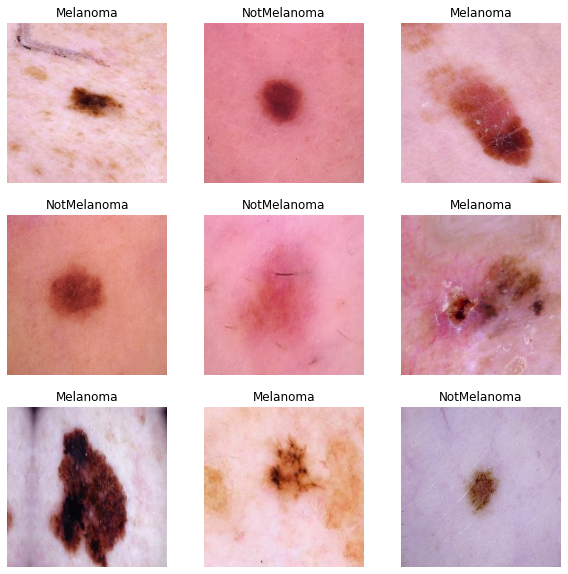

In [29]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [30]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = valid_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)

In [31]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# 2. Modeling
We are going to use transfer learning technique.

One of the simplist models that don't have large number of parameters in MobileNet. 

In [32]:
IMG_SHAPE = IMG_SIZE + (3,)

As we can see, MobileNet was originally trained on ImageNet.So, we are going to get these weights to reuse in our task.

In [33]:
base_model = tf.keras.applications..MobileNetV2(include_top=False,
                                              input_shape= IMG_SHAPE,
                                              weights= 'imagenet')

9420800/9406464 [==============================] - 40s 4us/step


In [34]:
base_model.trainable = False

In [35]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [38]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training= False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [39]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [40]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [41]:
root_lod_dir = os.path.join(os.curdir, 'my_logs')

In [42]:
import time

In [44]:
def get_run_log_dir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_lod_dir, run_id)

In [46]:
run_log_dir = get_run_log_dir()

In [48]:
tensorboard_cb = keras.callbacks.TensorBoard(run_log_dir)
history = model.fit(x= train_dataset, epochs=10, validation_data= validation_dataset)

Epoch 1/10


2022-05-18 14:43:27.807114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


334/334 [==============================] - ETA: 0s - loss: 0.4780 - accuracy: 0.7526

2022-05-18 14:44:23.205104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


334/334 [==============================] - 74s 204ms/step - loss: 0.4780 - accuracy: 0.7526 - val_loss: 0.2787 - val_accuracy: 0.8956
Epoch 2/10
334/334 [==============================] - 68s 203ms/step - loss: 0.2676 - accuracy: 0.8869 - val_loss: 0.2127 - val_accuracy: 0.9197
Epoch 3/10
334/334 [==============================] - 67s 201ms/step - loss: 0.2258 - accuracy: 0.9081 - val_loss: 0.1926 - val_accuracy: 0.9253
Epoch 4/10
334/334 [==============================] - 68s 202ms/step - loss: 0.2057 - accuracy: 0.9172 - val_loss: 0.1826 - val_accuracy: 0.9242
Epoch 5/10
334/334 [==============================] - 68s 202ms/step - loss: 0.1962 - accuracy: 0.9195 - val_loss: 0.1763 - val_accuracy: 0.9250
Epoch 6/10
334/334 [==============================] - 68s 202ms/step - loss: 0.1975 - accuracy: 0.9196 - val_loss: 0.1721 - val_accuracy: 0.9278
Epoch 7/10
334/334 [==============================] - 68s 202ms/step - loss: 0.1875 - accuracy: 0.9222 - val_loss: 0.1689 - val_accuracy: 0.9

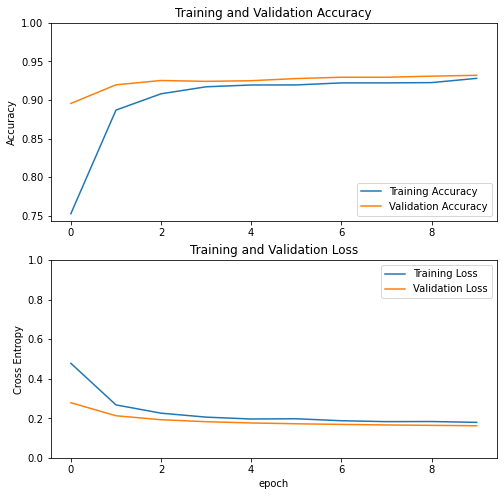

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [50]:
base_model.trainable = True

In [52]:
fine_tune_from_layer = 100
for layer in base_model.layers[:100]:
    layer.trainable = False

In [53]:
new_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=new_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [54]:
tensorboard_cb = keras.callbacks.TensorBoard(run_log_dir)
checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir, verbose=1, save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
model.fit(x=train_dataset, validation_data=validation_dataset, epochs = 30, callbacks=[checkpoint_cb, earlystopping_cb, tensorboard_cb])

Epoch 1/30


2022-05-18 15:49:09.393509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


334/334 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.9303

2022-05-18 15:50:23.051487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.14009, saving model to training_1


2022-05-18 15:50:45.245035: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: training_1/assets
334/334 [==============================] - 114s 321ms/step - loss: 0.1682 - accuracy: 0.9303 - val_loss: 0.1401 - val_accuracy: 0.9413
Epoch 2/30
334/334 [==============================] - ETA: 0s - loss: 0.1445 - accuracy: 0.9403
Epoch 2: val_loss improved from 0.14009 to 0.13611, saving model to training_1
INFO:tensorflow:Assets written to: training_1/assets
334/334 [==============================] - 108s 322ms/step - loss: 0.1445 - accuracy: 0.9403 - val_loss: 0.1361 - val_accuracy: 0.9461
Epoch 3/30
334/334 [==============================] - ETA: 0s - loss: 0.1289 - accuracy: 0.9453
Epoch 3: val_loss improved from 0.13611 to 0.12844, saving model to training_1
INFO:tensorflow:Assets written to: training_1/assets
334/334 [==============================] - 107s 320ms/step - loss: 0.1289 - accuracy: 0.9453 - val_loss: 0.1284 - val_accuracy: 0.9441
Epoch 4/30
334/334 [==============================] - ETA: 0s - loss: 0.1192 - accurac

In [60]:
! tensorboard --logdir=./my_logs --port=6006


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [57]:
loss, accuracy = model.evaluate(test_dataset)

112/112 [==============================] - 17s 149ms/step - loss: 0.1394 - accuracy: 0.9427


In [58]:
print('Test accuracy ', accuracy)
print('Test loss ', loss)

Test accuracy  0.9427127838134766
Test loss  0.13944177329540253


2022-05-18 16:27:24.299841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Predictions:
 [1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0]
Labels:
 [1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 0]


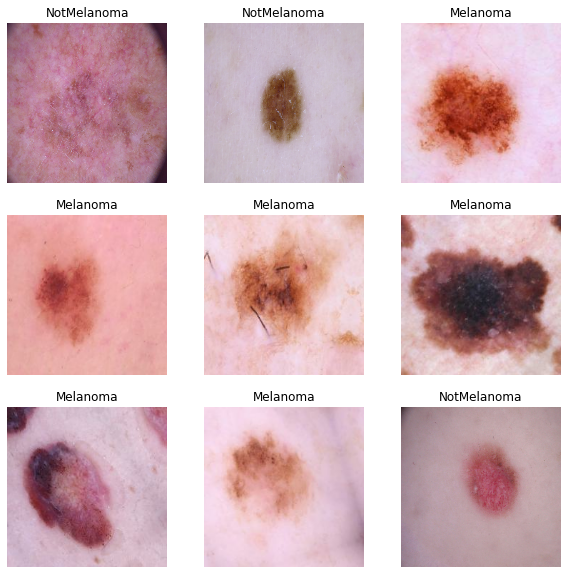

In [59]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")